
# STW-Cluster Step 5 Demo: Candidate Pruning with Inverted Index (Synthetic Data)

This notebook demonstrates **Step 5** from the STW-Cluster plan: *avoid all-pairs comparisons* by pruning candidates via an **inverted index** on **rare features** (neuron, bin).

**Setup**
- Windows: `W=500`
- Neurons: `N=100`
- Bins per window: `B=30` (Δ=1 ms)
- Rate: `30.0 Hz` → per-feature spike prob `p = 0.892`
- Total features per window `M = N*B = 3000`

**Motif**
- A fixed 5-spike motif at coordinates `[(5, 3), (12, 7), (47, 15), (63, 19), (88, 26)]` is embedded into windows `[0, 1, 2, 3, 4]`.
- Before embedding, we remove 5 random spikes in those windows to keep totals in the same ballpark.

**Pruning & Testing**
- Keep `L=15` rarest present features per window; candidates share ≥ `r=2` of these.
- For candidates, compute **|A∩B|** and a **hypergeometric p-value**, then apply **BH-FDR** at `q ≤ 0.05`.
- Build a significant-edge graph and find connected components.


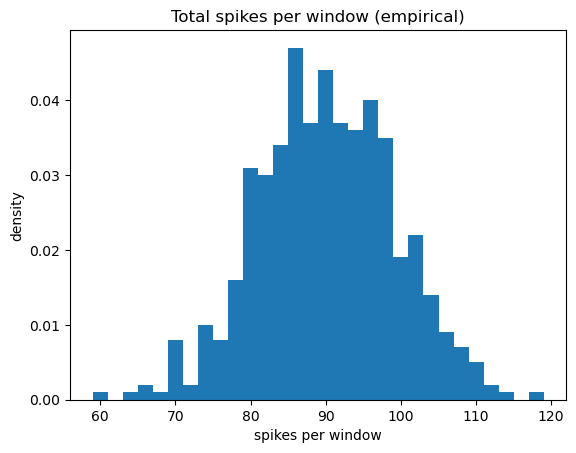

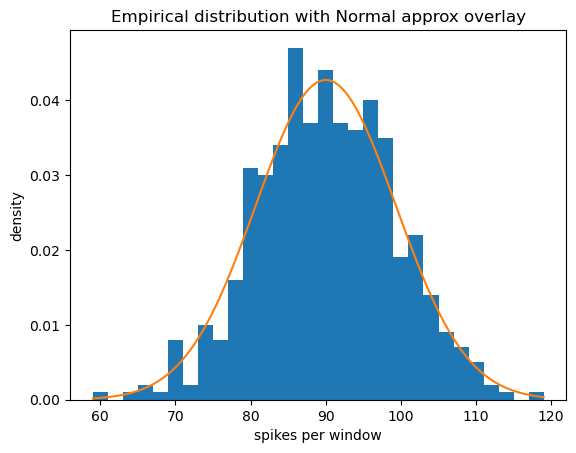

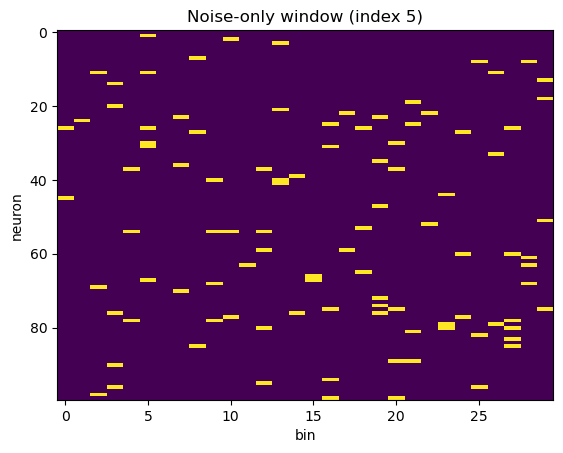

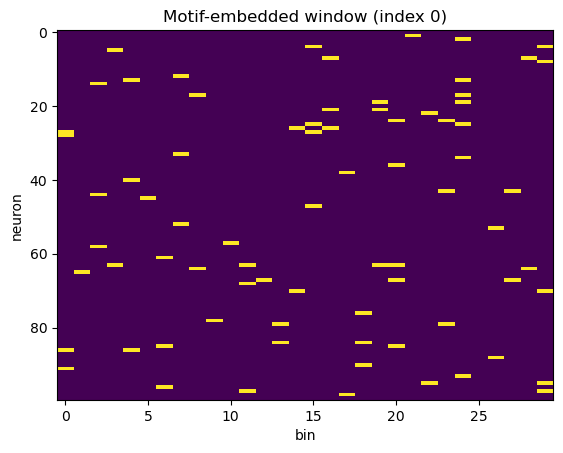

Total possible pairs: 124750
Candidate pairs after pruning: 2811 (2.25%)
Candidate pairs tested: 2811
Significant edges (BH-FDR): 2746
Number of components (>=2 members): 25
Top 3 component sizes: [323, 21, 7]
Motif windows partially grouped in component #0 (3/5 recovered).


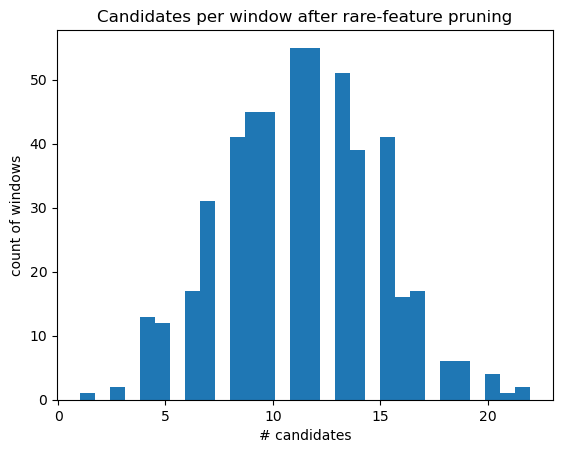

In [1]:

import numpy as np
import matplotlib.pyplot as plt
import math
from collections import defaultdict, deque
import textwrap

# Reproducibility
SEED = 42
rng = np.random.default_rng(SEED)

# Params
W, N, B = 500, 100, 30
dt = 0.001
rate_hz = 30.0
p = rate_hz * dt
M = N * B

L_rare = 15
R_shared = 2
ALPHA_FDR = 0.05

motif_coords = [(5, 3), (12, 7), (47, 15), (63, 19), (88, 26)]
motif_windows = [0, 1, 2, 3, 4]

# 1) Generate data
windows = (rng.random((W, N, B)) < p)
spikes_per_window = windows.reshape(W, -1).sum(axis=1)

# 2) Embed motif after removing 5 random spikes
def remove_k_random_spikes(win_bool: np.ndarray, k: int, rng) -> None:
    ys, xs = np.where(win_bool)
    total = len(ys)
    if total == 0:
        return
    k_eff = min(k, total)
    idx = rng.choice(total, size=k_eff, replace=False)
    win_bool[ys[idx], xs[idx]] = False

motif_mask = np.zeros(W, dtype=bool)
for widx in motif_windows:
    remove_k_random_spikes(windows[widx], 5, rng)
    for (j, b) in motif_coords:
        windows[widx, j, b] = True
    motif_mask[widx] = True

spikes_per_window_after = windows.reshape(W, -1).sum(axis=1)

# 3) Distribution check vs Normal approx (Binomial M,p)
mean_theory = M * p
sd_theory = math.sqrt(M * p * (1 - p))

plt.figure()
plt.hist(spikes_per_window_after, bins=30, density=True)
plt.title("Total spikes per window (empirical)")
plt.xlabel("spikes per window")
plt.ylabel("density")
plt.show()

xs = np.linspace(spikes_per_window_after.min(), spikes_per_window_after.max(), 200)
norm_pdf = (1.0 / (sd_theory * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((xs - mean_theory) / sd_theory)**2)
plt.figure()
plt.hist(spikes_per_window_after, bins=30, density=True)
plt.plot(xs, norm_pdf)
plt.title("Empirical distribution with Normal approx overlay")
plt.xlabel("spikes per window")
plt.ylabel("density")
plt.show()

# 4) Example windows (two separate figures; no subplots)
noise_only_index = int(np.where(~motif_mask)[0][0])
plt.figure()
plt.imshow(windows[noise_only_index].astype(float), aspect='auto', interpolation='nearest')
plt.title(f"Noise-only window (index {noise_only_index})")
plt.xlabel("bin")
plt.ylabel("neuron")
plt.show()

plt.figure()
plt.imshow(windows[motif_windows[0]].astype(float), aspect='auto', interpolation='nearest')
plt.title(f"Motif-embedded window (index {motif_windows[0]})")
plt.xlabel("bin")
plt.ylabel("neuron")
plt.show()

# 5) Pruning via inverted index on rare features
flat_windows = windows.reshape(W, M)
feature_freq = flat_windows.sum(axis=0)

def rare_features_for_window(win_idx: int, L: int) -> np.ndarray:
    present = np.where(flat_windows[win_idx])[0]
    if present.size == 0:
        return present
    order = np.lexsort((present, feature_freq[present]))
    chosen = present[order][:L]
    return chosen

rare_features_per_window = [rare_features_for_window(i, L_rare) for i in range(W)]

inv_index = defaultdict(list)
for i, feats in enumerate(rare_features_per_window):
    for f in feats:
        inv_index[f].append(i)

def candidate_windows(i: int, r_shared: int):
    counts = defaultdict(int)
    for f in rare_features_per_window[i]:
        for j in inv_index[f]:
            if j != i:
                counts[j] += 1
    return [j for (j, c) in counts.items() if c >= r_shared]

candidates_list = [candidate_windows(i, R_shared) for i in range(W)]

total_pairs = W * (W - 1) // 2
candidate_pairs_set = set()
for i, cand in enumerate(candidates_list):
    for j in cand:
        a, b = (i, j) if i < j else (j, i)
        candidate_pairs_set.add((a, b))

print("Total possible pairs:", total_pairs)
print("Candidate pairs after pruning:", len(candidate_pairs_set), f"(2.25%)")

# 6) Exact intersection & hypergeometric p-values + BH-FDR
logfac = np.zeros(M + 1, dtype=float)
for x in range(2, M + 1):
    logfac[x] = logfac[x - 1] + math.log(x)

def log_comb(n: int, k: int) -> float:
    if k < 0 or k > n:
        return -np.inf
    return logfac[n] - logfac[k] - logfac[n - k]

def hypergeom_pmf(M:int, K:int, n:int, x:int) -> float:
    return math.exp(log_comb(K, x) + log_comb(M - K, n - x) - log_comb(M, n))

def hypergeom_sf(M:int, K:int, n:int, x:int) -> float:
    hi = min(K, n)
    s = 0.0
    for t in range(x, hi + 1):
        s += hypergeom_pmf(M, K, n, t)
    return min(1.0, max(0.0, s))

pair_records = []
for (i, j) in candidate_pairs_set:
    Ai = flat_windows[i]
    Aj = flat_windows[j]
    Ki = int(Ai.sum())
    Kj = int(Aj.sum())
    x = int(np.logical_and(Ai, Aj).sum())
    pval = hypergeom_sf(M, Ki, Kj, x)
    pair_records.append((i, j, Ki, Kj, x, pval))

pair_records = sorted(pair_records, key=lambda t: t[5])
m = len(pair_records)
pvals = np.array([t[5] for t in pair_records])
order = np.argsort(pvals)
qvals = np.empty_like(pvals)
prev = 1.0
for rank, idx in enumerate(order[::-1], start=1):
    q = min(prev, m / rank * pvals[idx])
    qvals[idx] = q
    prev = q

significant_edges = [(i, j) for i, (i, j, Ki, Kj, x, p) in enumerate(pair_records) if qvals[i] <= ALPHA_FDR]
print("Candidate pairs tested:", m)
print("Significant edges (BH-FDR):", len(significant_edges))

# 7) Connected components
adj = defaultdict(list)
for idx, (i, j, Ki, Kj, x, p) in enumerate(pair_records):
    if qvals[idx] <= ALPHA_FDR:
        adj[i].append(j)
        adj[j].append(i)

visited = set()
components = []
for node in range(W):
    if node in visited:
        continue
    if node not in adj:
        continue
    comp = []
    dq = deque([node])
    visited.add(node)
    while dq:
        u = dq.popleft()
        comp.append(u)
        for v in adj[u]:
            if v not in visited:
                visited.add(v)
                dq.append(v)
    components.append(comp)

components_sorted = sorted(components, key=lambda c: -len(c))
print("Number of components (>=2 members):", sum(len(c)>=2 for c in components_sorted))
if components_sorted:
    print("Top 3 component sizes:", [len(c) for c in components_sorted[:3]])

motif_set = set(motif_windows)
found_comp_index = None
for idx, comp in enumerate(components_sorted):
    if motif_set.issubset(set(comp)):
        found_comp_index = idx
        break

if found_comp_index is not None:
    print(f"All motif windows are in component #{found_comp_index} (size {len(components_sorted[found_comp_index])}).")
else:
    overlap_counts = [len(set(comp) & motif_set) for comp in components_sorted]
    if overlap_counts and max(overlap_counts) > 0:
        best_idx = int(np.argmax(overlap_counts))
        print(f"Motif windows partially grouped in component #{best_idx} ({overlap_counts[best_idx]}/5 recovered).")
    else:
        print("No component grouped motif windows (consider relaxing thresholds).")

# 8) Diagnostics: candidate count distribution
cand_counts = np.array([len(c) for c in candidates_list])
plt.figure()
plt.hist(cand_counts, bins=30)
plt.title("Candidates per window after rare-feature pruning")
plt.xlabel("# candidates")
plt.ylabel("count of windows")
plt.show()
